## Notebook to test out freesufer stats output without using freesurfer utilities

In [24]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
    

In [29]:
data_dir = "/home/nikhil/projects/brain_changes/data/"
exp_setup_dir = f"{data_dir}exp_setup"

ukbb_dir = f"{exp_setup_dir}/ukbb/"
adni_dir = f"{exp_setup_dir}/adni/"

# UKB Paths
ukbb_demographics_csv = f"{ukbb_dir}ukbb_exp_data_demographics.csv" 
ukbb_DKT_csv = f"{ukbb_dir}ukbb_exp_data_DKT.csv" 

# ADNI Paths
adni_demographics_csv = f"{adni_dir}adni_exp_data_demographics.csv" 
adni_DKT_csv = f"{adni_dir}adni_exp_data_DKT.csv" 


# DKT fields and labels
ukbb_dkt_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_FS_DKT_Fields.csv"
ukbb_dkt_ct_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_DKT_CT_Fields.csv"

# ASEG fields and labels
ukbb_aseg_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_FS_ASEG_Fields.csv"
ukbb_aseg_vol_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_ASEG_vol_Fields.csv"

In [30]:
DKT_fields_df = pd.read_csv(ukbb_dkt_ct_fields)
DKT_fields_sorted = list(DKT_fields_df.sort_values(["hemi","roi"])["Field ID"].astype(str).values)


## Helper functions

In [78]:
def get_anat_change(BL_df, FU_df):
    """ Function to calculate *SUBJECT-LEVEL* average change and similarity in anatomical features between two visits. 
        change = BL - FU
        similarty = BL corrwith FU        
    """
    diff_df = BL_df - FU_df

    avg_diff_df = diff_df.mean(axis=1).copy().reset_index()
    avg_diff_df = avg_diff_df.rename(columns={0:"Avg Change"})

    corr_df = BL_df.corrwith(FU_df,axis=1).reset_index()
    corr_df = corr_df.rename(columns={0:"inter-visit-corr"})

    return avg_diff_df, corr_df


## Read agg CSVs after collating stats

### Note: 
- Desikan-Killiany-Tourville Atlas: Cortical Regions. Frontal pole, temporal pole, and “banks of the superior temporal sulcus” regions were removed as per the DKT protocol, 

### Read UKB data

In [146]:
CT_DKT_df = pd.read_csv(ukbb_DKT_csv)
CT_DKT_df = CT_DKT_df.set_index("subject_id")
CT_DKT_ses_2_df = CT_DKT_df[CT_DKT_df["session"]=="ses-2"][DKT_fields_sorted]
CT_DKT_ses_3_df = CT_DKT_df[CT_DKT_df["session"]=="ses-3"][DKT_fields_sorted]

# Diff = BL - FU
CT_diff_df = CT_DKT_ses_2_df - CT_DKT_ses_3_df
CT_diff_df = CT_diff_df.reset_index()
print(f"Shape of CT_DKT_df: {CT_diff_df.shape}")

CT_diff_df.head()

Shape of CT_DKT_df: (4309, 63)


,subject_id,27174,27175,27176,27177,27178,27179,27180,27204,27181,...,27287,27288,27289,27290,27291,27292,27293,27294,27295,27296
0,sub-1000635,-0.131,0.078,0.073,0.029,0.030,0.130,0.147,0.023,0.017,...,0.051,0.180,0.090,-0.146,0.105,0.008,-0.043,0.145,0.108,0.093
1,sub-1004084,0.174,-0.061,0.039,-0.060,-0.069,-0.044,-0.129,-0.117,-0.036,...,-0.135,-0.075,-0.048,-0.055,-0.034,-0.120,-0.023,-0.010,0.005,-0.034
2,sub-1008391,-0.263,-0.035,0.024,0.248,-0.065,-0.083,-0.155,0.074,0.067,...,0.054,0.202,0.013,-0.180,-0.056,-0.088,-0.006,0.128,0.038,-0.145
3,sub-1009663,0.186,0.017,-0.019,0.039,-0.035,-0.014,0.027,0.010,0.067,...,0.027,-0.001,0.030,-0.041,-0.027,-0.091,-0.039,-0.025,-0.024,0.044
4,sub-1010063,0.028,0.004,0.002,0.206,0.050,0.075,0.103,0.075,0.010,...,0.137,0.017,0.036,0.067,-0.020,0.063,0.070,0.009,0.024,-0.059


### Merge demographics
 Sex: 0 (Female), 1 (Male)

In [147]:
ukbb_demographics = pd.read_csv(ukbb_demographics_csv)
ukbb_demographics["subject_id"] = "sub-" + ukbb_demographics["eid"].astype("str")

demo_cols = ["subject_id", "age_at_ses2", "sex"]
CT_diff_df = pd.merge(CT_diff_df,ukbb_demographics[demo_cols], on="subject_id", how="left")


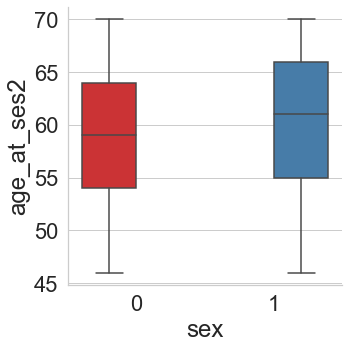

In [148]:
plot_df = CT_diff_df.copy()
palette = 'Set1'
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="sex",y="age_at_ses2", hue="sex", kind="box", palette=palette, data=plot_df)

#### CT diff (range of variation across ROIs)

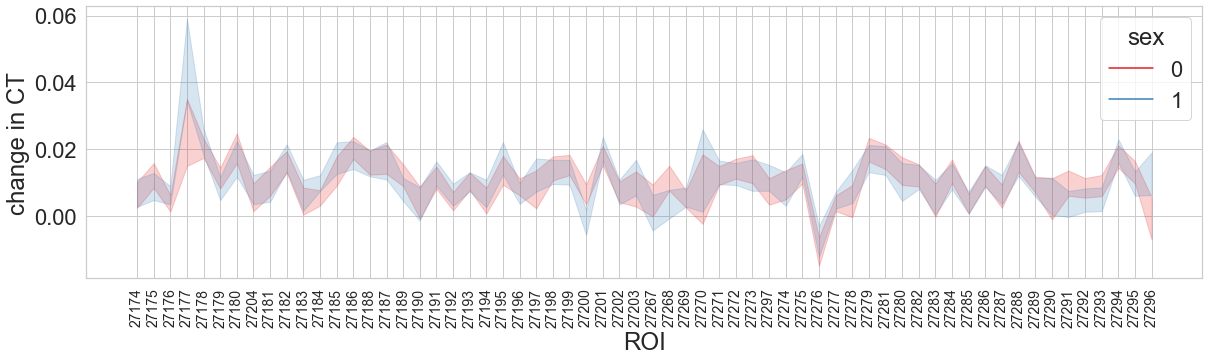

In [149]:
CT_diff_df_melt = CT_diff_df.melt(
    id_vars=demo_cols,
    var_name="ROI", 
    value_name="change in CT",
)

plot_df = CT_diff_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

palette = 'Set1'
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    fig,ax=plt.subplots(figsize=(20,5))
    g = sns.lineplot(x="ROI",y="change in CT", hue="sex", palette=palette, 
    linestyle="",data=plot_df,ax=ax)
    
    g.tick_params(axis='x', rotation=90, labelsize=14)

#### Structural covariance

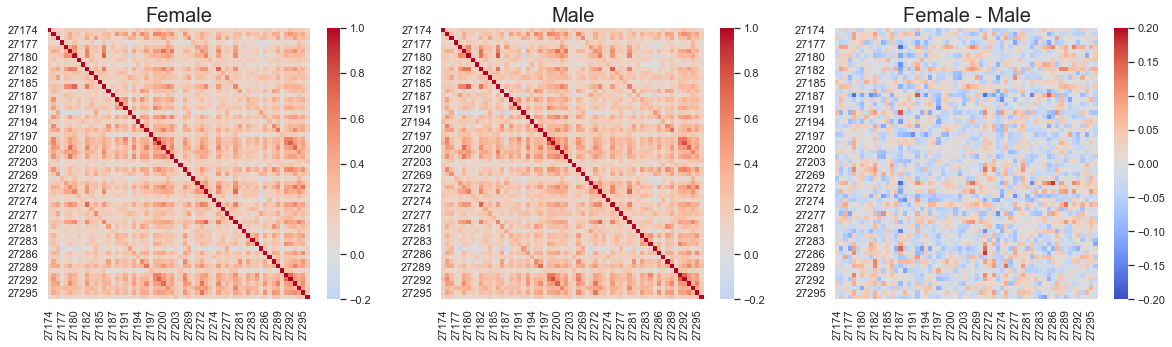

In [133]:
female_CT_diff_df = CT_diff_df[CT_diff_df["sex"]==0][DKT_fields_sorted]
male_CT_diff_df = CT_diff_df[CT_diff_df["sex"]==1][DKT_fields_sorted]

female_CT_diff_covar = female_CT_diff_df.corr()
male_CT_diff_covar = male_CT_diff_df.corr()

female_male_covar_diff = female_CT_diff_covar - male_CT_diff_covar

sns.set(font_scale=1)
palette = "coolwarm"
with sns.axes_style("whitegrid"):
    fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
    ax=axes[0]
    g = sns.heatmap(female_CT_diff_covar,ax=ax,vmin=-0.2, vmax=1, center=0,cmap=palette)
    ax.set_title("Female", fontsize=20)
    ax=axes[1]
    g = sns.heatmap(male_CT_diff_covar,ax=ax,vmin=-0.2, vmax=1, center=0,cmap=palette)
    ax.set_title("Male", fontsize=20)

    ax=axes[2]
    g = sns.heatmap(female_male_covar_diff,ax=ax,vmin=-0.2, vmax=0.2, center=0,cmap=palette)
    ax.set_title("Female - Male", fontsize=20)

    

#### Age-CT Correlation

In [150]:
age_CT_corr_df = CT_diff_df.copy()
age_CT_corr_df = age_CT_corr_df.dropna(axis=0, how="any")

female_ages = age_CT_corr_df[age_CT_corr_df["sex"]==0]["age_at_ses2"]
male_ages = age_CT_corr_df[age_CT_corr_df["sex"]==1]["age_at_ses2"]

print(f"n_females: {len(female_ages)}, n_males: {len(male_ages)}")
ages = {0: female_ages, 1: male_ages}

corr_list = []

for roi in DKT_fields_sorted:
    for sex in [0,1]:
        ct_diff = age_CT_corr_df[age_CT_corr_df["sex"]==sex][roi]
        r, pval = scipy.stats.pearsonr(ages[sex], ct_diff)
        corr_list.append((roi,sex,r,pval))
        
corr_df = pd.DataFrame()
corr_df[["ROI","sex","r","pval"]] = corr_list

n_females: 2053, n_males: 1710


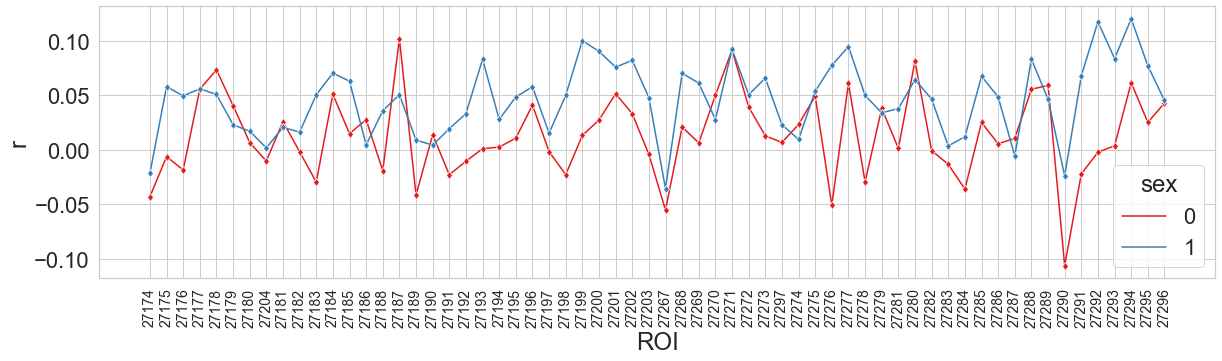

In [135]:
plot_df = corr_df.copy()
sns.set(font_scale=2)
palette = 'Set1'
with sns.axes_style("whitegrid"):
    fig,ax=plt.subplots(figsize=(20,5))
    g = sns.lineplot(x="ROI",y="r",hue="sex", linestyle="-", palette=palette, marker="d", data=plot_df,ax=ax)
    g.tick_params(axis='x', rotation=90, labelsize=14)

### Subject-wise change

In [106]:
CT_avg_diff_df, CT_corr_df = get_anat_change(CT_DKT_ses_2_df,CT_DKT_ses_3_df)

CT_avg_diff_df = pd.merge(CT_avg_diff_df, ukbb_demographics[["subject_id","sex"]], on="subject_id")
CT_corr_df = pd.merge(CT_corr_df, ukbb_demographics[["subject_id","sex"]], on="subject_id")

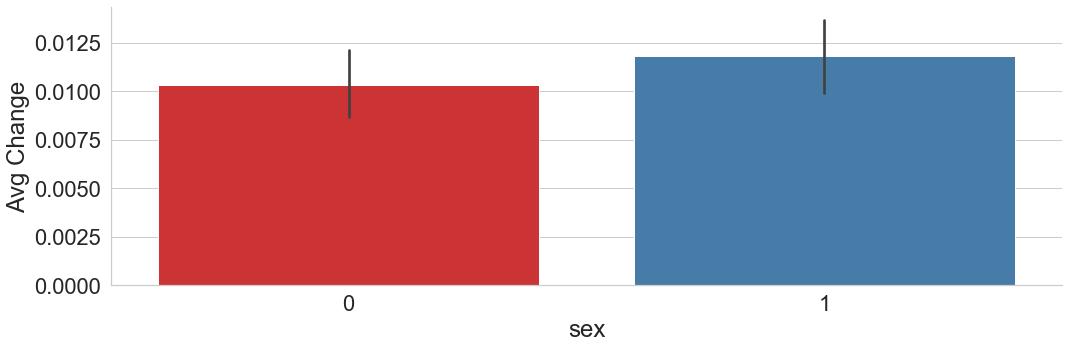

In [107]:
plot_df = CT_avg_diff_df.copy()
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="sex",y="Avg Change",kind="bar",aspect=3,data=plot_df, palette=palette)


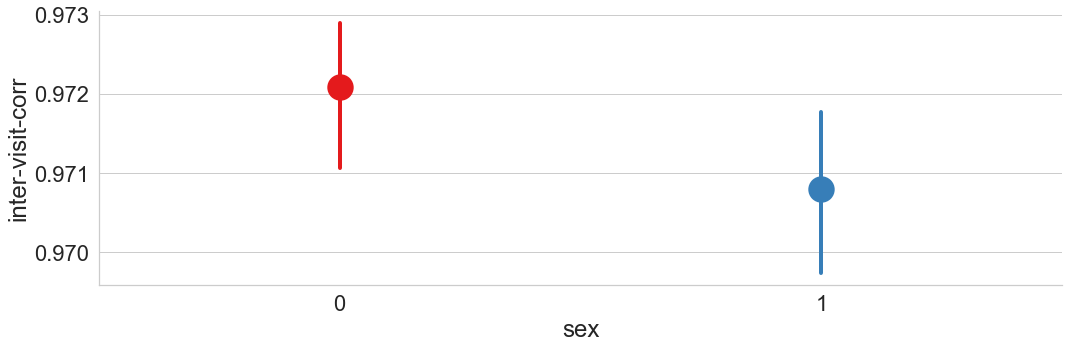

In [109]:
plot_df = CT_corr_df.copy()

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="inter-visit-corr",x="sex", kind="point", 
    hue="sex", scale=3, errwidth=4, palette=palette, aspect=3, data=plot_df)

## Read ADNI data

In [76]:
CT_DKT_df = pd.read_csv(adni_DKT_csv)
CT_DKT_df = CT_DKT_df.set_index("subject_id")
CT_DKT_ses_bl_df = CT_DKT_df[CT_DKT_df["session"]=="ses-bl"][DKT_fields_sorted]
CT_DKT_ses_m24_df = CT_DKT_df[CT_DKT_df["session"]=="ses-m24"][DKT_fields_sorted]

# Diff = BL - FU
CT_diff_df = CT_DKT_ses_bl_df - CT_DKT_ses_m24_df
CT_diff_df = CT_diff_df.reset_index()
print(f"Shape of CT_DKT_df: {CT_diff_df.shape}")

CT_diff_df.head()

Shape of CT_DKT_df: (1089, 63)


,subject_id,27174,27175,27176,27177,27178,27179,27180,27204,27181,...,27287,27288,27289,27290,27291,27292,27293,27294,27295,27296
0,sub-ADNI127S0431,0.060,0.060,0.045,0.721,0.079,0.001,0.137,0.115,0.039,...,0.022,0.072,0.032,0.189,0.077,0.081,0.074,0.100,0.024,0.153
1,sub-ADNI035S0341,-0.015,0.193,0.123,0.047,0.184,0.217,0.078,0.001,-0.134,...,-0.038,0.346,0.162,-0.082,0.124,-0.006,0.114,0.077,0.172,0.426
2,sub-ADNI114S6063,-0.014,0.011,-0.123,0.090,0.046,-0.062,-0.019,-0.136,-0.182,...,-0.204,-0.088,-0.114,0.068,0.043,0.002,-0.133,-0.012,-0.071,-0.193
3,sub-ADNI006S0498,-0.300,-0.014,-0.026,0.208,-0.013,-0.064,-0.006,0.065,0.007,...,-0.105,-0.168,-0.096,0.022,-0.096,0.050,0.094,0.004,-0.156,-0.129
4,sub-ADNI033S0511,-0.096,-0.008,-0.090,0.536,0.072,0.135,0.167,0.112,0.094,...,0.058,-0.130,0.130,-0.113,-0.033,0.052,0.095,0.097,0.079,0.156


### Merge demographics

In [71]:
adni_demographics = pd.read_csv(adni_demographics_csv)
adni_demographics = adni_demographics.rename(columns={"participant_id":"subject_id"})

CT_diff_df = pd.merge(CT_diff_df,adni_demographics, on="subject_id", how="left")

## Plots

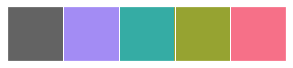

In [72]:
dx_order = ["CN","SMC","EMCI","LMCI","AD"]
cohort_order = ["ADNI1","ADNI2","ADNI3"] #ADNIGO only has EMCI

## Colors
pal = sns.color_palette(["#636363"]) + sns.color_palette("husl", 4)[::-1]
sns.palplot(pal)

### ROI-wise distribution

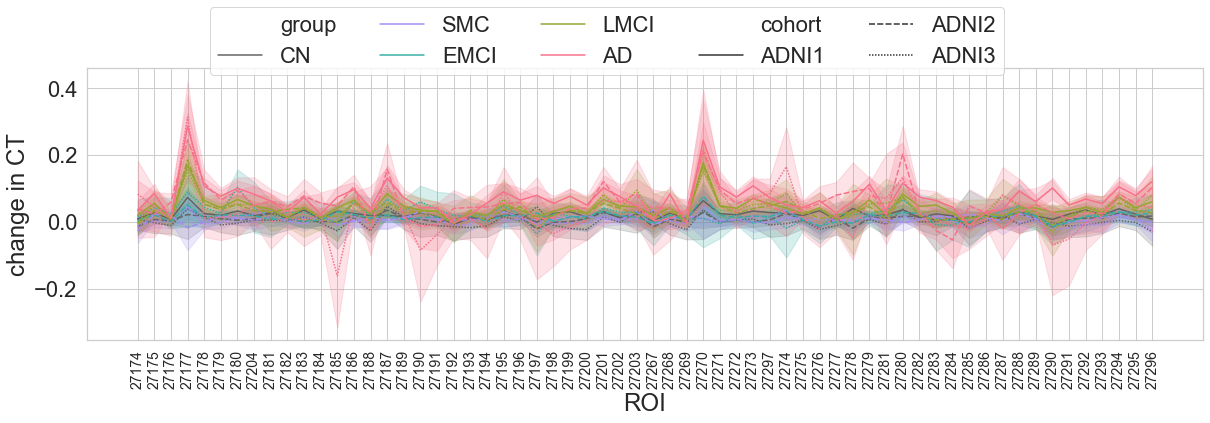

In [75]:
CT_diff_df_melt = CT_diff_df.melt(
    id_vars=["subject_id","age","sex","group","COLPROT","ORIGPROT"],
    var_name="ROI", 
    value_name="change in CT",
)
CT_diff_df_melt.head()

plot_df = CT_diff_df_melt.copy()
plot_df = plot_df.rename(columns={"ORIGPROT":"cohort"})
plot_df["ROI"] = plot_df["ROI"].astype(str)

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    fig,ax=plt.subplots(figsize=(20,5))
    # g = sns.catplot(x="ROI",y="CT",kind="point",hue="DX_bl",hue_order=hue_order, linestyle="",palette=pal, aspect=4,data=plot_df)
    g = sns.lineplot(x="ROI",y="change in CT", #order=DKT_fields_sorted: Not easy to change order
    hue="group",hue_order=dx_order, style="cohort", style_order=cohort_order,
    linestyle="",palette=pal,data=plot_df,ax=ax)
    
    g.tick_params(axis='x', rotation=90, labelsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(0.1, 1.1), ncol=5)


### Subject-wise change

In [82]:
CT_avg_diff_df, CT_corr_df = get_anat_change(CT_DKT_ses_bl_df,CT_DKT_ses_m24_df)

CT_avg_diff_df = pd.merge(CT_avg_diff_df, adni_demographics[["subject_id","group","ORIGPROT"]], on="subject_id")
CT_corr_df = pd.merge(CT_corr_df, adni_demographics[["subject_id","group","ORIGPROT"]], on="subject_id")

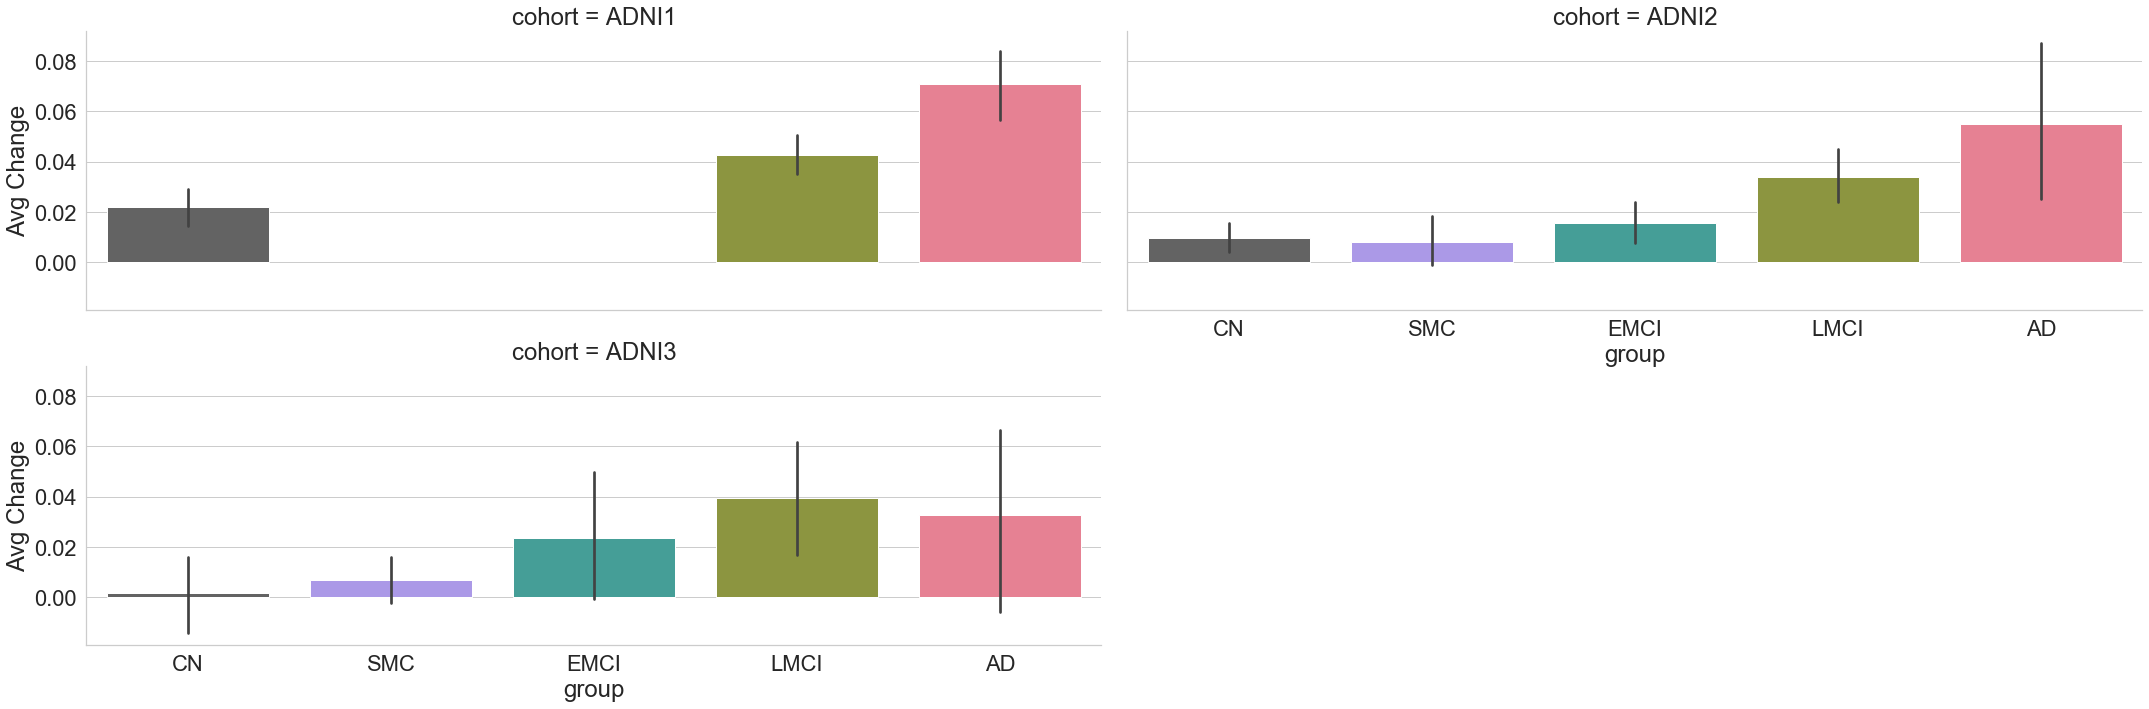

In [83]:
plot_df = CT_avg_diff_df.copy()
plot_df = plot_df.rename(columns={"ORIGPROT":"cohort"})
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="group",y="Avg Change",col="cohort", kind="bar", col_wrap=2,
    order=dx_order, col_order=cohort_order, aspect=3,data=plot_df, palette=pal)


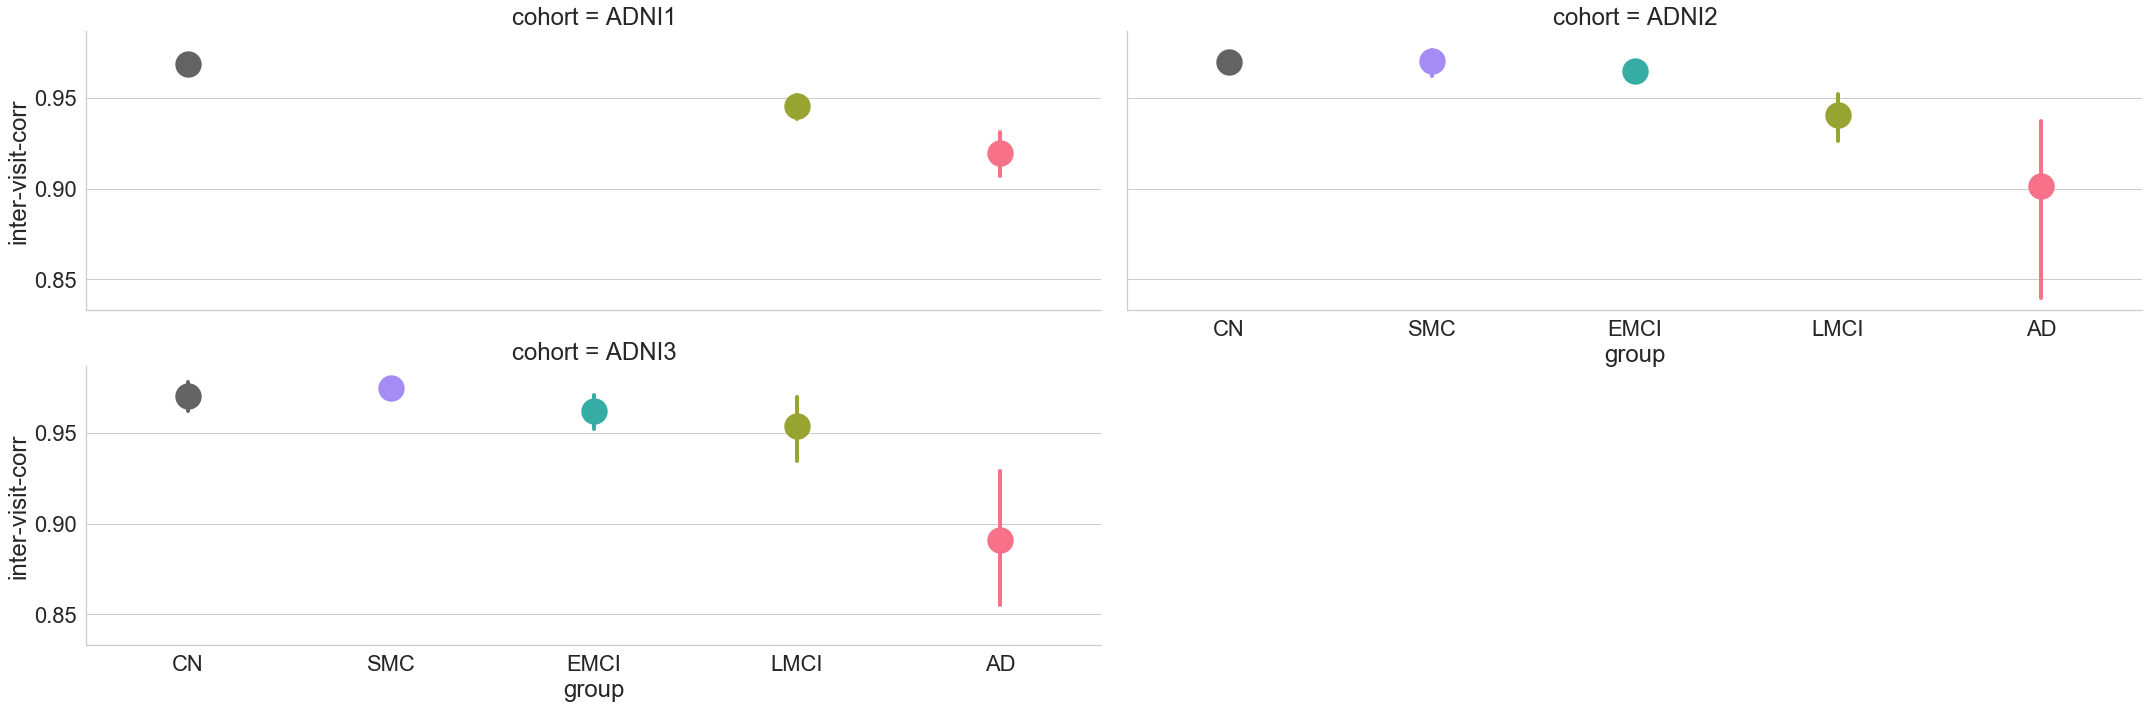

In [86]:
plot_df = CT_corr_df.copy()
plot_df = plot_df.rename(columns={"ORIGPROT":"cohort"})

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="inter-visit-corr",x="group", order=dx_order, kind="point", 
    hue="group", hue_order=dx_order,
    col="cohort", col_wrap=2, col_order=cohort_order,
    scale=3, errwidth=4, palette=pal, aspect=3, data=plot_df)